<a href="https://colab.research.google.com/github/lnsayer/udemy_ml_course/blob/main/02_pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [2]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [3]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

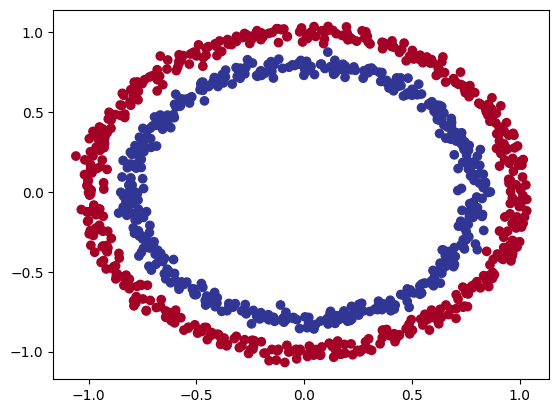

In [5]:
# Visualise with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### Let's find out how we could build a PyTorch neural network to classify dots into red(0) and blue(1)

You can familiarise yourself with the shape of the data you're working with to get over tensor mismatches etc.

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X[0]

array([0.75424625, 0.23148074])

In [8]:
# Turn our data into tensors
# Otherwise this causes issues with computations later on
import torch
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

X_tensor[:5], y_tensor[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Let's create a model class that:
1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`)
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of X and y
3. Defines a `forward` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

In [11]:
# 1. Construct a model class that subclasses nn.Module

from torch import nn

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # 3. Define a forward method containing the forward pass computation
  def forward(self, x):
    # Return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x))
# 4. Create an instance of the model and send it to target device

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear

In [12]:
# Replicate CircleModelv0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\n First 10 predictions {untrained_preds[:10]}")
print(f"\n First 10 test labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

 First 10 predictions tensor([[0.2468],
        [0.3738],
        [0.2809],
        [0.2356],
        [0.8638],
        [0.9369],
        [0.8327],
        [0.9660],
        [0.2562],
        [0.3888]], grad_fn=<SliceBackward0>)

 First 10 test labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
untrained_preds.squeeze_()
untrained_preds[:10], untrained_preds.shape

(tensor([0.2468, 0.3738, 0.2809, 0.2356, 0.8638, 0.9369, 0.8327, 0.9660, 0.2562,
         0.3888], grad_fn=<SliceBackward0>),
 torch.Size([200]))

In [15]:
import numpy as np
x = np.array([-2.2, -1.4, -.8, .2, .4, .8, 1.2, 2.2, 2.9, 4.6])
x.reshape(-1, 1)

array([[-2.2],
       [-1.4],
       [-0.8],
       [ 0.2],
       [ 0.4],
       [ 0.8],
       [ 1.2],
       [ 2.2],
       [ 2.9],
       [ 4.6]])

In [16]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)

In [17]:
# Create accuracy function
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  return correct/len(y_pred)

In [18]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2468],
        [0.3738],
        [0.2809],
        [0.2356],
        [0.8638]], grad_fn=<SliceBackward0>)

The raw outputs of our model are referred to as logits . They are the unnormalised outputs and we need to normalise them to make proper predictions about the data.

In [19]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5614],
        [0.5924],
        [0.5698],
        [0.5586],
        [0.7035]], grad_fn=<SigmoidBackward0>)

In [20]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]
# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [22]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_0.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCEloss you need torch.sigmoid()
  #                             y_train)

  loss = loss_fn(y_logits, y_train) # Using nn.BCEWithLogitsLoss works with raw logits
  acc= accuracy(y_true = y_train,
                y_pred = y_pred)
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backwards
  loss.backward()

  #5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy(y_test,
                        test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.3f} ")

Epoch: 0 | Test loss: 0.73945 | Test acc: 0.500 
Epoch: 10 | Test loss: 0.73523 | Test acc: 0.500 
Epoch: 20 | Test loss: 0.73153 | Test acc: 0.520 
Epoch: 30 | Test loss: 0.72831 | Test acc: 0.560 
Epoch: 40 | Test loss: 0.72549 | Test acc: 0.575 
Epoch: 50 | Test loss: 0.72303 | Test acc: 0.565 
Epoch: 60 | Test loss: 0.72087 | Test acc: 0.550 
Epoch: 70 | Test loss: 0.71898 | Test acc: 0.530 
Epoch: 80 | Test loss: 0.71732 | Test acc: 0.525 
Epoch: 90 | Test loss: 0.71586 | Test acc: 0.525 


Let's make a plot of our model's predictions, the data it's trying to predict and the decision boundary it's creating for whether something is class 0 or class 1.

In [23]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


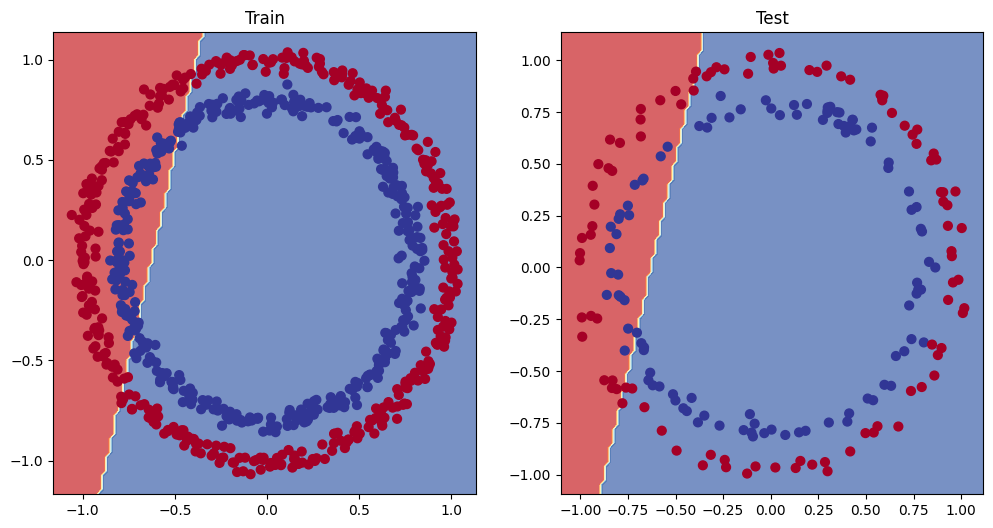

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [25]:
# Let's create a new model with more layers and run for longer
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [27]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69261, Test acc: 0.51%
Epoch: 100 | Loss: 0.69305, Accuracy: 0.50% | Test loss: 0.69379, Test acc: 0.48%
Epoch: 200 | Loss: 0.69299, Accuracy: 0.51% | Test loss: 0.69437, Test acc: 0.46%
Epoch: 300 | Loss: 0.69298, Accuracy: 0.52% | Test loss: 0.69458, Test acc: 0.45%
Epoch: 400 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69465, Test acc: 0.46%
Epoch: 500 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69467, Test acc: 0.46%
Epoch: 600 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%
Epoch: 700 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%
Epoch: 800 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%
Epoch: 900 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%


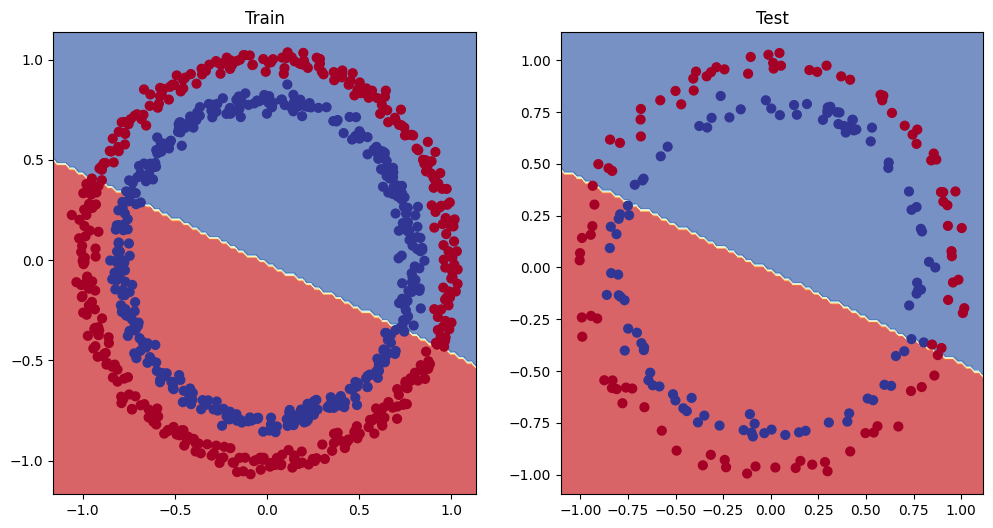

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Skipped the part about using our model for linear regression. Let's put a non-linear activation function in between the hidden layers in the forward pass.

In [29]:
# Build a model with non-linea activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features = 1)
    self.relu = nn.ReLU() # Could also put sigmoid in the function

  def forward(self, x):
    # Intersperse the ReLU activaiton function between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr =0.1)


## Training a model with non-linearity

In [31]:
# Fit the model
torch.manual_seed(42)

# Define number of epochs
epochs = 4000
train_loss_arr = np.zeros(epochs)
test_loss_arr = np.zeros(epochs)

# Put all data onto target device
X_train, y_train, X_test, y_test = map(lambda x: x.to(device), [X_train, y_train, X_test, y_test])

for epoch in range(epochs):
  continue
  # Put the model in training mode
  model_3.train()
  # 1.  Forward pass
  y_logits = model_3(X_train).squeeze() # otherwise shape is torch.Size([800, 1])
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediciton probabilities -> prediciton labels

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
  train_loss_arr[epoch] = loss
  acc = accuracy(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_loss_arr[epoch] = test_loss
    test_acc = accuracy(y_test, test_pred)


  # Print out what's happening
  if epoch % 100 == 0 :
    print(f"Epoch: {epoch}, Accuracy: {acc:.2f}, Loss: {loss:.5f}, \
    Test_accuracy: {test_acc:.2f}, Test_loss: {test_loss:.5f}")

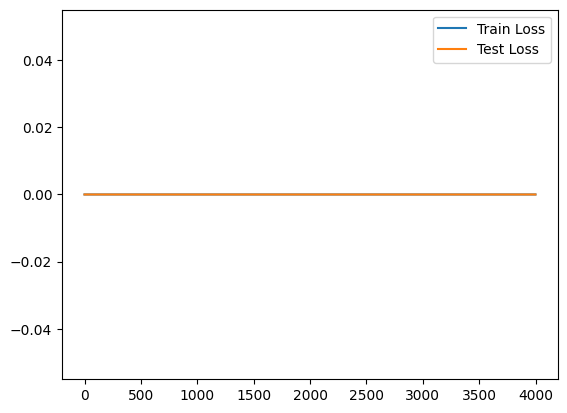

In [32]:
plt.plot(train_loss_arr, label="Train Loss")
plt.plot(test_loss_arr, label="Test Loss")
plt.legend()


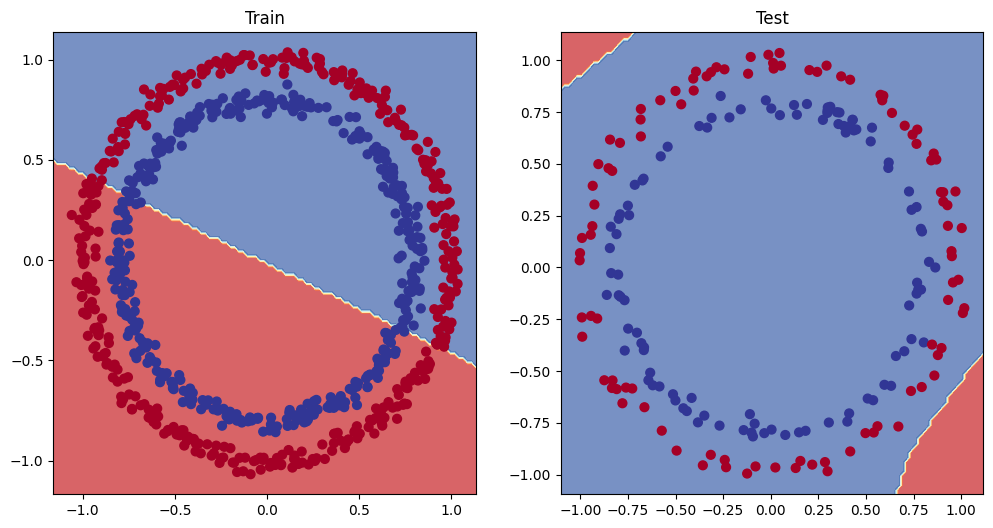

In [33]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 has no non-linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 has non-linearity


## 8. Putting things together by building a multi-class PyTorch model


tensor([[  8.3628,  -1.4119],
        [  7.1679,  -1.0376],
        [-10.6830,   7.4437],
        [ 10.3625,  -0.6271],
        [  3.6212,  -3.4547]]) tensor([0, 0, 3, 0, 0])


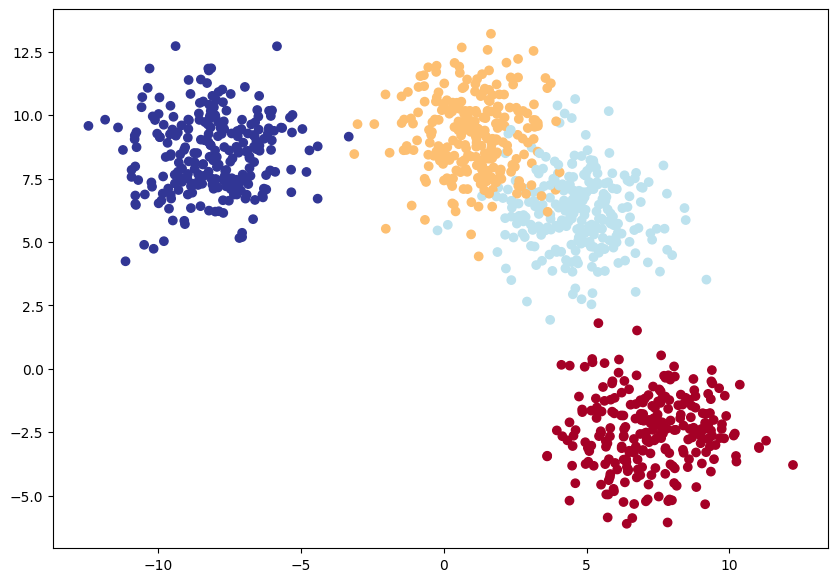

In [95]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 32

# 1. Create multi-class-data
X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES, # X features
                           centers=NUM_CLASSES, # y labels
                            cluster_std = 1.5, # give the clusters a little shake up
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob,
            cmap=plt.cm.RdYlBu);

In [96]:
print(y_blob_test)

tensor([2, 1, 2, 0, 3, 3, 0, 2, 1, 2, 0, 0, 0, 0, 3, 1, 0, 3, 1, 1, 3, 3, 3, 0,
        2, 2, 2, 1, 0, 1, 3, 3, 3, 3, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 1, 2, 3, 0, 2, 0, 2, 1, 2, 2, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3,
        1, 2, 3, 1, 2, 3, 1, 1, 3, 1, 3, 0, 0, 3, 2, 3, 0, 0, 3, 0, 0, 0, 2, 1,
        3, 0, 3, 1, 0, 0, 1, 0, 1, 3, 2, 0, 3, 1, 3, 1, 1, 1, 2, 3, 0, 0, 2, 1,
        0, 1, 3, 0, 2, 3, 1, 0, 1, 2, 3, 2, 2, 1, 1, 1, 1, 3, 1, 2, 3, 3, 1, 1,
        0, 1, 2, 3, 3, 0, 1, 1, 1, 2, 3, 1, 3, 2, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1,
        2, 2, 3, 0, 2, 0, 3, 3, 2, 3, 0, 3, 2, 3, 1, 1, 3, 0, 2, 0, 2, 0, 1, 3,
        3, 1, 3, 3, 3, 1, 3, 3])


Let's create a subclass of nn.Module that takes in three hyperparameters:
- `input_features` The number of `X` features coming into the model
- ` output_features` the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES`
- `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.


In [97]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [98]:
from torch import nn

# setting number of input features to NUM_FEATURES
input_features = NUM_FEATURES
# setting number of output features to NUM_CLASSES
output_features = NUM_CLASSES
# setting number of hidden neurons in each hidden layer
hidden_units = 20

# Class to create blob classifier. Inherits from nn.Module.
class Blobclassifier(nn.Module):
  def __init__(self):
    super().__init__()
    # First layer
    self.input_layer = nn.Linear(in_features= input_features,
                             out_features = hidden_units)
    # First hidden layer
    self.hidden_layer_1 = nn.Linear(in_features = hidden_units,
                                    out_features = hidden_units)
    # Second hidden layer
    self.hidden_layer_2 = nn.Linear(in_features = hidden_units,
                                    out_features = hidden_units)
    # Output layer
    self.output_layer = nn.Linear(in_features = hidden_units,\
                                   out_features = output_features)
    # Creating an instance of nn.ReLU()
    self.relu = nn.ReLU()

  # Forward pass of the function
  def forward(self, x):
    return self.output_layer(self.relu(self.hidden_layer_2\
           (self.relu(self.hidden_layer_1(self.relu(self.\
           input_layer(x)))))))

  # This does not have to be in the class since it does not reference to self
  def loss_fn(self, input, y):
    loss = nn.CrossEntropyLoss()
    return loss(input, y)

print(model_blob)

Blobclassifier(
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (hidden_layer_1): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layer_2): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=4, bias=True)
  (relu): ReLU()
)


In [105]:
# number of epochs to train over
epochs = 100
torch.manual_seed(42)

# will use pytorch's own accuracy function
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Creating an instance of the Blobclassifier and moving it to the device
model_blob = Blobclassifier().to(device)
# Creating an instance of the SGD method
optimizer = torch.optim.SGD(params = model_blob.parameters(),
                            lr=0.1)

# Creating empty arrays so we can plot the train, test loss and accuracies
train_loss_arr = np.zeros(epochs)
test_loss_arr = np.zeros(epochs)
train_acc_arr = np.zeros(epochs)
test_acc_arr = np.zeros(epochs)

# Moving the data to the device
X_blob_train, y_blob_train, X_blob_test, y_blob_test = map(lambda x: x.to(device), [X_blob_train, y_blob_train, X_blob_test, y_blob_test])

# Loop over the number of epochs
for epoch in range(epochs):
  # put the model in training mode
  model_blob.train()

  # 1. Forward Pass
  # Calculate logits
  train_logits = model_blob.forward(X_blob_train)
  # Calculate probabilities from logits
  train_prob = torch.softmax(train_logits, dim=1)
  # Calculate class predictions from probabilities
  train_pred = train_prob.argmax(dim=1)

  # Calculate the accuracy of the model at this epoch and add to train_acc_arr
  metric = Accuracy(num_classes = NUM_CLASSES)
  train_acc = metric(train_pred, y_blob_train)
  train_acc_arr[epoch] = train_acc


  # 2. Calculate the loss and add to train_loss_arr
  train_loss = model_blob.loss_fn(train_prob, y_blob_train)
  train_loss_arr[epoch] = train_loss

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss
  train_loss.backward()

  # 5. Update the optimizer (gradient descent)
  optimizer.step()

  # Testing
  model_blob.eval()
  # Put the model in inference_mode so it does not keep track of gradients
  with torch.inference_mode():
    # Calculate logits
    test_logits = model_blob.forward(X_blob_test)
    # Calculate probabilities from logits
    test_prob = torch.softmax(test_logits, dim=1)
    # Calculate class predictions from probabilities
    test_pred = test_prob.argmax(dim=1)
    # Calculate the accuracy of the model at this epoch and add to train_acc_arr
    metric = Accuracy(num_classes = NUM_CLASSES)
    test_acc = metric(test_pred, y_blob_test)
    test_acc_arr[epoch] = test_acc

    # Calculate the loss and add to train_loss_arr
    test_loss = model_blob.loss_fn(test_prob, y_blob_test)
    test_loss_arr[epoch] = test_loss

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | \
       Test loss: {test_loss:.3f} | Train accuracy: {train_acc:.3f} \
      | Test accuracy: {test_acc:.3f} ")

Epoch: 0 | Train loss: 1.370 |        Test loss: 1.362 | Train accuracy: 0.449       | Test accuracy: 0.515 
Epoch: 10 | Train loss: 1.313 |        Test loss: 1.298 | Train accuracy: 0.496       | Test accuracy: 0.515 
Epoch: 20 | Train loss: 1.189 |        Test loss: 1.165 | Train accuracy: 0.496       | Test accuracy: 0.515 
Epoch: 30 | Train loss: 1.095 |        Test loss: 1.070 | Train accuracy: 0.664       | Test accuracy: 0.735 
Epoch: 40 | Train loss: 1.016 |        Test loss: 0.985 | Train accuracy: 0.733       | Test accuracy: 0.795 
Epoch: 50 | Train loss: 0.943 |        Test loss: 0.919 | Train accuracy: 0.909       | Test accuracy: 0.935 
Epoch: 60 | Train loss: 0.874 |        Test loss: 0.863 | Train accuracy: 0.971       | Test accuracy: 0.970 
Epoch: 70 | Train loss: 0.835 |        Test loss: 0.830 | Train accuracy: 0.975       | Test accuracy: 0.965 
Epoch: 80 | Train loss: 0.816 |        Test loss: 0.813 | Train accuracy: 0.975       | Test accuracy: 0.960 
Epoch: 90 |

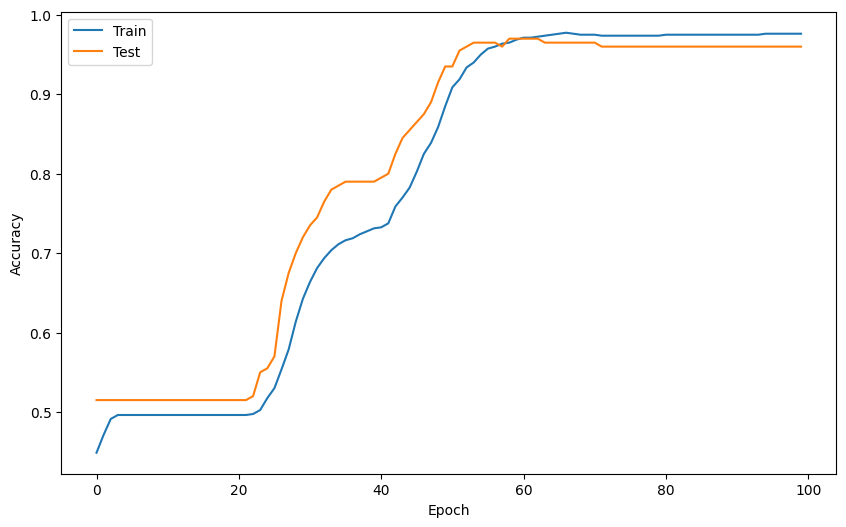

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

ax.plot(np.arange(epochs), train_acc_arr, label = 'Train')
ax.plot(np.arange(epochs), test_acc_arr, label= 'Test')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.legend();

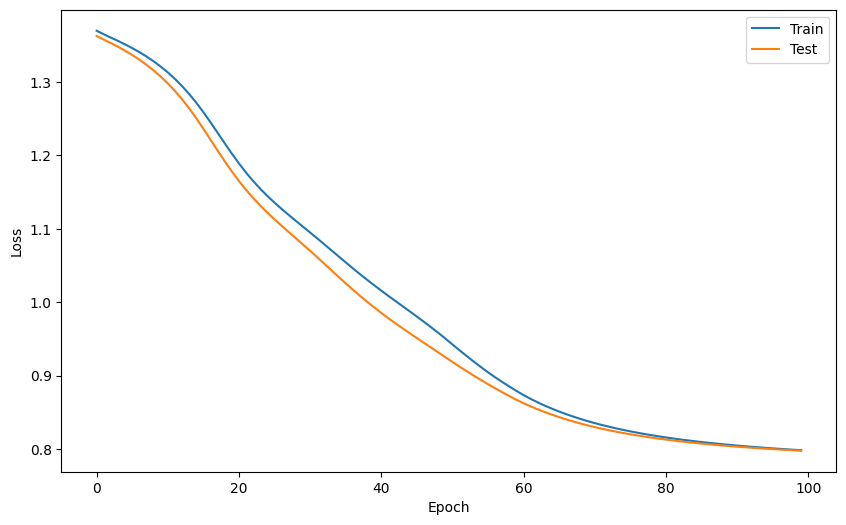

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

ax.plot(np.arange(epochs), train_loss_arr, label = 'Train')
ax.plot(np.arange(epochs), test_loss_arr, label= 'Test')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend();

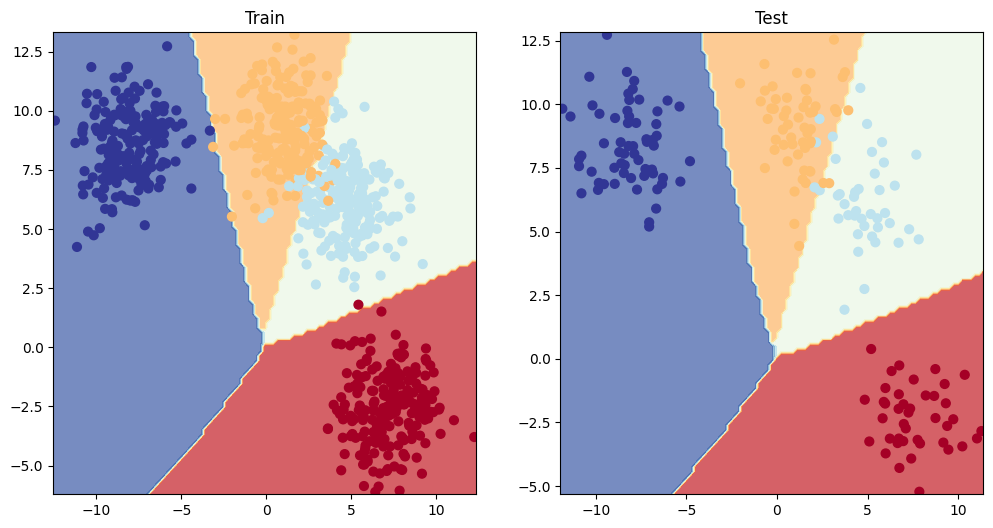

In [112]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_blob, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_blob, X_blob_test, y_blob_test)